In [ ]:
from google.colab import drive
import os
import sys

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
cls_filepath ="drive/MyDrive/NLU Coursework/" #Path to the directory containing the classes folder

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Setup

## Imports

In [ ]:
sys.path.append(cls_filepath) #Path to import the helper methods & classes from. Classes directory must be within this folder
from classes.evaluation import evaluate, draw_confusion_matrix, most_confused_samples
from classes.preprocessing import load_data, augment_data

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler,random_split
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaModel, get_constant_schedule_with_warmup, get_cosine_schedule_with_warmup, get_linear_schedule_with_warmup
from torch.nn import Linear, AvgPool2d, CrossEntropyLoss, Dropout, Tanh
from keras.utils import to_categorical

import torch

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import typing
from PIL import Image
import json
import gensim.downloader as api
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
import string

## Primary Variables

Filepath variables

In [ ]:
solution_dir = os.path.join(cwk_dir, "solution_C")
models_dir = os.path.join(solution_dir, "models_C")
results_dir = os.path.join(solution_dir, "results")

Training variables

In [ ]:
INITIAL_LR: float = 2e-5
EPOCHS: int = 6
VALIDATION_SPLIT: float = 0.2
BATCH_SIZE: int = 16

# BERT_ID: str = 'bert-base-uncased'
BERT_ID: str = 'roberta-base'
NUM_LABELS: int = 2

BERT Keys

In [ ]:
INPUTS_IDS_KEY: str = "input_ids"
ATTENTION_MASK_KEY: str = "attention_mask"
TOKEN_TYPE_KEY: str = "token_type_ids"

Other

In [ ]:
MAX_SEQ_LENGTH: int = 512 #None is the value to denote that there is no max length. Max length is recommended
VOCAB_SIZE: int = None #None is the value to denote that there is no vocab size yet. This is set later, once we have the training data
EMBEDDING_SIZE: int = None

## Functions

In [ ]:
def tokenize_data(tokenizer: RobertaTokenizer, premises: typing.List[str], hypotheses: typing.List[str], maxlen: int) ->typing.Tuple[np.array, np.array]:
  """
  Uses the input tokenizer to tokenizer the premises & hypotheses together. Will padd/truncate the sequences of tokens correctly. Formats the sequences together of the format below

      sample = [CLS] Premise [SEP] Hypothesis [SEP]
  """
  return tokenizer(premises, hypotheses, max_length=maxlen, padding="max_length", truncation=True, return_tensors="pt", add_special_tokens=True)

In [ ]:
def get_accuracy(preds, labels) -> float:
  """
  Gets the accuracy between the predictions and labels. Returns this float
  """
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
test = [1,2,3,4,5]
index = 3
test = test[:(index - 1)] + test[(index):]
test

[1, 2, 4, 5]

# Data Preprocessing

## Load Data

In [ ]:
(train_premises, train_hypotheses, train_labels), (dev_premises, dev_hypotheses, dev_labels) = load_data(cwk_dir)

In [ ]:
dev_premises_og = dev_premises
dev_hypotheses_og = dev_hypotheses

In [ ]:
train_labels = torch.tensor([int(x) for x in train_labels])
dev_labels = torch.tensor([int(x) for x in dev_labels])

### Data Augmentation
Different data augmentations are inspired by the paper found [here](https://link.springer.com/article/10.1186/s40537-021-00492-0)

In [ ]:
print(f"{len(train_premises)} samples before augmentation")
train_premises, train_hypotheses, train_labels = augment_data(train_premises, train_hypotheses, train_labels, premise_quantity = 3, hypothesis_quantity=3)
train_labels = torch.tensor(train_labels)
print(f"{len(train_premises)} samples after augmentation")

26944 samples before augmentation
48515 samples after augmentation


## Tokenize Data

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained(BERT_ID, do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
train_data = tokenize_data(tokenizer=tokenizer, premises=list(train_premises), hypotheses=list(train_hypotheses), maxlen=MAX_SEQ_LENGTH)
dev_data = tokenize_data(tokenizer=tokenizer, premises=list(dev_premises), hypotheses=list(dev_hypotheses), maxlen=MAX_SEQ_LENGTH) #Dev is used for evaluation

### Example

In [ ]:
print(f"Sentence: {tokenizer.convert_ids_to_tokens(train_data[INPUTS_IDS_KEY][0])}")
print(f"Tokens: {train_data[INPUTS_IDS_KEY]}")

Sentence: ['<s>', 'However', ',', 'ĠFort', 'ĠCharles', 'Ġwas', 'Ġrebuilt', 'Ġas', 'Ġa', 'Ġmilitary', 'Ġand', 'Ġnaval', 'Ġgarrison', ',', 'Ġand', 'Ġit', 'Ġprotected', 'ĠJamaica', 'Ġand', 'Ġmuch', 'Ġof', 'Ġthe', 'ĠEnglish', 'ĠCaribbean', 'Ġfor', 'Ġ250', 'Ġyears', 'Ġuntil', 'Ġthe', 'Ġadvent', 'Ġof', 'Ġste', 'ams', 'hips', 'Ġand', 'Ġyet', 'Ġanother', 'Ġearthquake', 'Ġin', 'Ġ1907', 'Ġsaw', 'Ġits', 'Ġdecline', '.', '</s>', '</s>', 'Fort', 'ĠCharles', 'Ġwas', 'Ġrebuilt', 'Ġas', 'Ġan', 'Ġamusement', 'Ġpark', 'Ġfor', 'Ġthe', 'Ġlocals', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pa

In [ ]:
VOCAB_SIZE = tokenizer.vocab_size
print(f"Vocabulary size: {VOCAB_SIZE}")

Vocabulary size: 50265


## Format Dataset & Dataloader

In [ ]:
dataset = TensorDataset(train_data[INPUTS_IDS_KEY], train_data[ATTENTION_MASK_KEY], train_labels)
test_dataset = TensorDataset(dev_data[INPUTS_IDS_KEY], dev_data[ATTENTION_MASK_KEY], dev_labels) #note here that the dev dataset is used for testing (evaluation) later

In [ ]:
train_dataset, val_dataset = random_split(dataset, [(1 - VALIDATION_SPLIT), VALIDATION_SPLIT])

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

# Model Training

## Model Architecture
Inspiration:
- https://arxiv.org/pdf/2105.03791.pdf
- https://aclanthology.org/D15-1075.pdf

A larger network is better:
- https://arxiv.org/pdf/2110.01518.pdf

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
model = RobertaForSequenceClassification.from_pretrained(BERT_ID, num_labels=NUM_LABELS)

model = model.to(device)
model

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

## Learning Rate

In [ ]:
OPTIM = torch.optim.AdamW(model.parameters(), lr=INITIAL_LR)

num_warmup_steps = int(len(train_dataset) * 1)
num_training_steps = int(len(train_dataset) * EPOCHS)
SCHEDULER = get_linear_schedule_with_warmup(OPTIM, num_warmup_steps = num_warmup_steps, num_training_steps = num_training_steps)

print(f"num_warmup_steps: {num_warmup_steps}")
print(f"num_training_steps: {num_training_steps}")

num_warmup_steps: 38864
num_training_steps: 233184


## Model Training

In [ ]:
#Loss metric
loss_function = CrossEntropyLoss().to(device)

In [ ]:
patience = 2
min_delta = 0.01
best_val_loss = 1000
current_patience = 0

best_model_filename: str = "best_solution_C.pt"

In [ ]:
for epoch in range(EPOCHS):
  ## Training
  model.train()
  total_loss = 0
  total_accuracy = 0
  for batch in train_dataloader:
    OPTIM.zero_grad()

    input_ids, attention_mask, labels = [part.to(device) for part in batch]

    outputs = model(input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels)

    loss = outputs.loss
    total_loss += loss.item()
    loss.backward()

    total_accuracy += get_accuracy(outputs.logits.detach().cpu().numpy(), labels.to('cpu').numpy())

    OPTIM.step()
    SCHEDULER.step()

  avg_train_loss = total_loss / len(train_dataloader)
  avg_train_accuracy = total_accuracy / len(train_dataloader)
  print(f"Epoch {epoch+1}, Train Average Accuracy: {avg_train_accuracy}, Training Average Loss: {avg_train_loss}")

  ##Validation
  model.eval()
  total_val_accuracy = 0
  total_val_loss = 0

  for batch in val_dataloader:
    input_ids, attention_mask, labels = [part.to(device) for part in batch]

    with torch.no_grad():
      outputs = model(input_ids = input_ids,
                      attention_mask = attention_mask,
                      labels=labels)

    loss = outputs.loss.detach().cpu().numpy()
    logits = outputs.logits.detach().cpu().numpy()
    total_val_loss  += loss.item()

    total_val_accuracy += get_accuracy(logits, labels.to('cpu').numpy())

  avg_val_accuracy = total_val_accuracy / len(val_dataloader)
  avg_val_loss = total_val_loss / len(val_dataloader)

  print(f"Epoch {epoch+1}, Validation Average Accuracy: {avg_val_accuracy}, Validation Average Loss: {avg_val_loss}")

  #Early stopping
  if avg_val_loss < (best_val_loss - min_delta):
    best_val_loss = avg_val_loss
    current_patience = 0

    #Save the best model so far
    torch.save(model.state_dict(), os.path.join(models_dir, best_model_filename))
    print(f"Best model recorded at epoch {epoch+1}")
  else:
    current_patience += 1
    if current_patience >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

Epoch 1, Train Average Accuracy: 0.50537772745986, Training Average Loss: 0.6975276974455816
Epoch 1, Validation Average Accuracy: 0.642406798245614, Validation Average Loss: 0.664470794953798
Best model recorded at epoch 1
Epoch 2, Train Average Accuracy: 0.7799505969534788, Training Average Loss: 0.46029876915146756
Epoch 2, Validation Average Accuracy: 0.8315858004385965, Validation Average Loss: 0.38622917982406524
Best model recorded at epoch 2
Epoch 3, Train Average Accuracy: 0.8500668999588308, Training Average Loss: 0.34425945689969956
Epoch 3, Validation Average Accuracy: 0.8509457236842105, Validation Average Loss: 0.34885755574673805
Best model recorded at epoch 3
Epoch 4, Train Average Accuracy: 0.8843145327295183, Training Average Loss: 0.27830680645158773
Epoch 4, Validation Average Accuracy: 0.8667763157894737, Validation Average Loss: 0.3472947622695325
Epoch 5, Train Average Accuracy: 0.9128756689995883, Training Average Loss: 0.21690758174003863
Epoch 5, Validation Av

In [ ]:
torch.save(model.state_dict(), os.path.join(models_dir, "solution_C.pt"))

# Model Evaluation
Here we have balanced data & both classes are equally important. Therefore it is best to look at the macro-averaged performance metrics. Below details the metrics of:
- Accuracy
- Loss
- Precision
  - Macro
  - Weighted Macro
- Recall
  - Macro
  - Weighted Macro
- F-Score
  - Macro
  - Weighted Macro
- MCC


In [ ]:
#Get the predictions for all of the test cases
predicted_logits = []

for batch in test_dataloader:
  input_ids, attention_mask, labels = [part.to(device) for part in batch]

  with torch.no_grad():
    outputs = model(input_ids = input_ids,
                    attention_mask = attention_mask,
                    labels=labels)

  predicted_logits.extend(outputs.logits.detach().cpu())

In [ ]:
#Evaluation metrics
test_metrics = evaluate(true_labels=np.array(dev_labels), predicted_logits=np.array(predicted_logits))
test_metrics.to_csv(os.path.join(results_dir, "roberta_metrics.csv"), index=False)
test_metrics.head()

,Accuracy,Precision,Macro Precision,Weighted Macro Precision,Recall,Macro Recall,Weighted Macro Recall,F1-Score,Macro F1-Score,Weighted Macro F1-Score,MCC,Loss
0,0.873683,0.901559,0.874467,0.875348,0.847901,0.874549,0.873683,0.873907,0.873682,0.87369,0.749016,1.849316


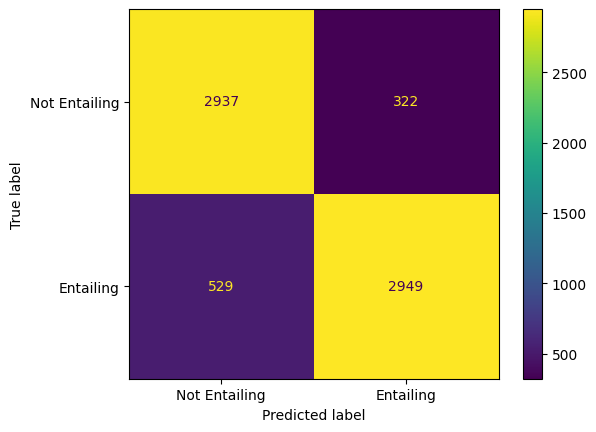

In [ ]:
conf_mat = draw_confusion_matrix(true_labels=np.array(dev_labels), predicted_logits=np.array(predicted_logits))

In [ ]:
df = most_confused_samples(true_logits=to_categorical(dev_labels), predicted_logits=np.array(predicted_logits), premises=dev_premises_og, hypotheses=dev_hypotheses_og, num=10)
df.to_csv(os.path.join(results_dir, f"roberta_most_confused.csv"), index=False)
df

,Premise,Hypothesis,Loss,Predicted Label,True Label
0,The traditional word for the API is pharmacon ...,The traditional word for the API is pharmacon ...,16.118095,1,1
1,She received basic training in music when her ...,She received basic training in music when her ...,16.118095,1,1
2,Mon Dieu!,This person is speaking English.,16.118095,1,0
3,The Chair and Ranking Member of the committee(...,The Chair and Ranking Member of the committee(...,16.118095,1,1
4,It may have been the most poorly performed mar...,Although it was the possibly the worst martial...,16.118095,1,1
5,Re-Analysis of NMMAPS Morbidity Data and Furth...,The re-analysis of NMMAPS morbidity data is a ...,16.118095,1,1
6,"'Tis the spring entertaining season again, in ...",Spring is entertainment season in New York,16.118095,1,1
7,The Vatican was upset when the fascist youth m...,The Catholic Boy Scouts were a fascist organiz...,16.118095,1,0
8,The teeming millions living in Calcutta and Mu...,The millions of people living in Calcutta and ...,16.118095,1,1
9,Room 17 houses a once private collection that ...,The collection in Room 17 is quite interesting...,16.118095,1,1
